# Segmenting and Clustering of Neighborhoods of Toronto

## Step: 1 - Web Scraping

#### Web Scraping using BeautifulSoup Library

##### We will import the necessary libraries for web scrapping like request, BeautifulSoup and pandas

In [158]:
import requests 
from bs4 import BeautifulSoup
import pandas as pd

##### We will create a html of the URL using request.get("your URl") then finally converting that into text 

In [159]:
website_html = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text

##### 1. Lets create a BeautifulSoup object with inputs as our website_html and parser as 'lxml'
##### 2. After inspecting the html file, create a variable (Toronto_Table) and store the table in html file using "find" function with inputs param as table and class as'wikitable sortable'
##### 3. Fnd all rows of the table using the param 'tr' and store them in a variable Table_rows excluding the header row (which is empty)

In [160]:
soup = BeautifulSoup(website_html,'lxml')
Toronto_Table = soup.find('table',{'class':'wikitable sortable'})
Table_rows = Toronto_Table.findAll('tr')[1:]

##### 1. Create a Table list for storing the rows without any 'tr' or 'td'
##### 2. Run a for loop to extract the rows from table rows by finding the rows excluding the tr using 'td' as param
##### 3. Then append the rows by extracting the text excluding the 'td' and replcaing \n with ""

In [161]:
Table = []
for tr in Table_rows:
    td = tr.findAll('td')
    Table.append([i.text.replace('\n',"") for i in td])

##### Finally, create a DataFrame using the Table by inserting the columns
##### I named column 'Neighborhood' as 'Neighborhoodd' because to avoid duplicate 'Neighborhood' created in future cells

In [162]:
df = pd.DataFrame(Table,columns = ['Postal Code','Borough','Neighborhoodd'])
print(df.head())
print('Number of rows : ',df.shape[0])

  Postal Code           Borough               Neighborhood
0         M1A      Not assigned               Not assigned
1         M2A      Not assigned               Not assigned
2         M3A        North York                  Parkwoods
3         M4A        North York           Victoria Village
4         M5A  Downtown Toronto  Regent Park, Harbourfront
Number of rows :  180


&emsp;

#### Web Scraping using Pandas Library

##### Web Scrapping with pandas is pretty easy compared to Beautiful soup
##### Directly create Dataframe by extracting the tables from the URL using pandas library

In [168]:
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')[0]
df.columns = ['Postal Code','Borough','Neighborhoodd']
print(df.head())
print('Number of rows : ',df.shape[0])

  Postal Code           Borough              Neighborhoodd
0         M1A      Not assigned               Not assigned
1         M2A      Not assigned               Not assigned
2         M3A        North York                  Parkwoods
3         M4A        North York           Victoria Village
4         M5A  Downtown Toronto  Regent Park, Harbourfront
Number of rows :  180


&emsp;

## Step: 2 - Pre Processing

##### Filter the rows which are having 'Borough' as 'Not assigned'

In [169]:
df_filtered = df[df['Borough']!='Not assigned'].reset_index(drop=True)
df_filtered

,Postal Code,Borough,Neighborhoodd
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C..."
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


##### Let's see the number of rowa before and after filtering

In [170]:
print("Number of rows in DataFrame before filtering : ",df.shape[0])
print("Number of rows in DataFrame after filtering : ",df_filtered.shape[0])

Number of rows in DataFrame before filtering :  180
Number of rows in DataFrame after filtering :  103


&emsp;

##### Mapping the location details using Geospatial_Coordinates.csv

In [171]:
latlng = pd.read_csv('Geospatial_Coordinates.csv')
df_Merged = pd.merge(df_filtered,latlng,on='Postal Code')
df_Merged.head()

,Postal Code,Borough,Neighborhoodd,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


&emsp;

##### Filter the rows where Borough contains 'Toronto'

In [172]:
df_toronto = df_Merged[df_Merged['Borough'].str.contains("Toronto")].reset_index(drop=True)
df_toronto.head()

,Postal Code,Borough,Neighborhoodd,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


&emsp;

##### Lets check the number of unique boroughs and number of rows

In [227]:
print('Number of unique boroughs in Toronto {}'.format(len(df_processed['Borough'].unique())))
print('Number of postal codes in Toronto {}'.format(df_processed.shape[0]))

Number of unique boroughs in Toronto 4
Number of postal codes in Toronto 39


&emsp;

##### 1. Let's find the nearby venues of each neighborhood of all boroughs in toronto
##### 2. We are using Foursquare API to leverage the data of nearby venues of each neighborhood

In [174]:
#function to find the near by venues
def getNearbyVenues(postalcodes,boroughs,names, latitudes, longitudes, radius=500):
    
    CLIENT_ID = 'T52QLCJW4ZPSRLZKTWMCXSEN1MTFEURSJNY0DOMF5TM5UZNV' # your Foursquare ID
    CLIENT_SECRET = 'HOICOSJAUHTSPDMDXCL1XCTOJZ0WQT5TTKREVX1HVPMFJE3Y' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    LIMIT = 100
    
    venues_list=[]
    
    for postalcode,borough,name, lat, lng in zip(postalcodes,boroughs,names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            postalcode,
            borough,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['postalcode','Borough','Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [176]:
Toronto_venues = getNearbyVenues(postalcodes=df_toronto['Postal Code'],
                                   boroughs=df_toronto['Borough'],
                                   names=df_toronto['Neighborhoodd'],
                                   latitudes=df_toronto['Latitude'],
                                   longitudes=df_toronto['Longitude']
                                  )

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West, Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
R

&emsp;

##### Let's look the Toronto_venues

In [177]:
Toronto_venues.head()

,postalcode,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65426,-79.360636,Dominion Pub and Kitchen,43.656919,-79.358967,Pub


&emsp;

##### Let's see how many venues exists in toronto

In [228]:
print('Number of venues in Toronto are {}'.format(Toronto_venues.shape[0]))

Number of venues in Toronto are 1617


&emsp;

##### Lets group the dataframe by Neighborhood

In [178]:
Toronto_venues.groupby('Neighborhood').count()

,postalcode,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,,,
Berczy Park,58,58,58,58,58,58,58,58
"Brockton, Parkdale Village, Exhibition Place",22,22,22,22,22,22,22,22
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",15,15,15,15,15,15,15,15
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",15,15,15,15,15,15,15,15
Central Bay Street,66,66,66,66,66,66,66,66
Christie,18,18,18,18,18,18,18,18
Church and Wellesley,74,74,74,74,74,74,74,74
"Commerce Court, Victoria Hotel",100,100,100,100,100,100,100,100
Davisville,33,33,33,33,33,33,33,33


&emsp;

##### Let's do the one hot encoding for venue category as we are going to cluster the neighbourhoods based on venues

In [179]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhoodd column back to dataframe
Toronto_onehot['Neighborhoodd'] = Toronto_venues['Neighborhood']  

# move neighborhood and venue column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot.head()

,Neighborhoodd,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


&emsp;

##### Let's group dataframe based on Neighborhood and take mean of each Neighborhood

In [180]:
Toronto_grouped = Toronto_onehot.groupby('Neighborhoodd').mean().reset_index()
Toronto_grouped.head()

,Neighborhoodd,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Berczy Park,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.017241,0.0,0.0,0.000000,0.0,0.0,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
2,"Business reply mail Processing Centre, South C...",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.066667
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.0,0.066667,0.066667,0.133333,0.133333,0.133333,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
4,Central Bay Street,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.015152,0.0,0.0,0.015152,0.0,0.0,0.015152


&emsp;

##### Let's see the top 10 venues of each neighborhood by sorting them based on venue category

In [181]:
#function to sort 
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [282]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhoodd']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhoodd'] = Toronto_grouped['Neighborhoodd']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhoodd,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Cheese Shop,Seafood Restaurant,Bakery,Beer Bar,Café,Restaurant,Hotel,Diner
1,"Brockton, Parkdale Village, Exhibition Place",Café,Breakfast Spot,Coffee Shop,Gym,Climbing Gym,Convenience Store,Burrito Place,Stadium,Restaurant,Italian Restaurant
2,"Business reply mail Processing Centre, South C...",Yoga Studio,Auto Workshop,Garden Center,Garden,Light Rail Station,Fast Food Restaurant,Farmers Market,Comic Shop,Park,Pizza Place
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Airport Service,Airport Terminal,Harbor / Marina,Boat or Ferry,Rental Car Location,Coffee Shop,Plane,Bar,Sculpture Garden
4,Central Bay Street,Coffee Shop,Japanese Restaurant,Sandwich Place,Italian Restaurant,Café,Burger Joint,Salad Place,Bar,Department Store,Thai Restaurant


## Step: 3 - Clustering and Segmentation of Toronto Neighborhoods

##### Let's find the best k value using elbow method

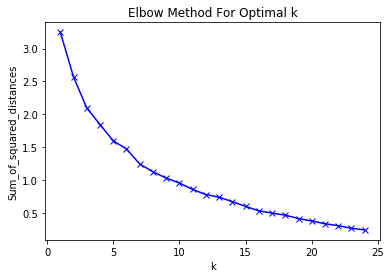

In [279]:
import matplotlib.pyplot as plt
Sum_of_squared_distances = []
K = range(1,25)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(Toronto_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

###### from above graph the best k value would be 6 (using elbow method)

&emsp;

In [283]:
# set number of clusters
from sklearn.cluster import KMeans
kclusters = 6 #best k value
Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhoodd', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 0, 2, 2, 0, 2, 2, 2, 2])

&emsp;

In [284]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Toronto_merged = df_toronto

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Toronto_merged = Toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhoodd'), on='Neighborhoodd')

Toronto_merged.head() # check the last columns!

,Postal Code,Borough,Neighborhoodd,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,2,Coffee Shop,Park,Pub,Bakery,Café,Breakfast Spot,Theater,Spa,Dessert Shop,Ice Cream Shop
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,2,Coffee Shop,Sushi Restaurant,Diner,Park,Bar,Beer Bar,Smoothie Shop,Sandwich Place,Burrito Place,Café
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,2,Clothing Store,Coffee Shop,Cosmetics Shop,Bubble Tea Shop,Middle Eastern Restaurant,Café,Japanese Restaurant,Italian Restaurant,Bookstore,Ramen Restaurant
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,2,Coffee Shop,Café,Cocktail Bar,American Restaurant,Restaurant,Gastropub,Lingerie Store,Department Store,Hotel,Gym
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,5,Neighborhood,Health Food Store,Pub,Trail,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Department Store,Donut Shop


## Step: 4 - Visualization of clusters

In [285]:
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors

address = 'Toronto'
geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [286]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighborhoodd'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

###### if you are not able see folium map go to the below link

[Go to this page and paste the githublink to render the folium map](https://nbviewer.jupyter.org/)

## Step: 5 - Analysis on Clusters

### 1st Cluster

In [287]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 0, Toronto_merged.columns[[2] + list(range(5, Toronto_merged.shape[1]))]]

,Neighborhoodd,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Christie,0,Grocery Store,Café,Park,Coffee Shop,Nightclub,Italian Restaurant,Restaurant,Baby Store,Candy Store,Athletics & Sports
9,"Dufferin, Dovercourt Village",0,Pharmacy,Bakery,Middle Eastern Restaurant,Music Venue,Park,Pet Store,Café,Brewery,Brazilian Restaurant,Bar
11,"Little Portugal, Trinity",0,Bar,Men's Store,Café,Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Asian Restaurant,Yoga Studio,Record Shop,Pizza Place
18,Lawrence Park,0,Photography Studio,Park,Bus Line,Swim School,Dessert Shop,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Donut Shop
22,"High Park, The Junction South",0,Café,Thai Restaurant,Mexican Restaurant,Arts & Crafts Store,Music Venue,Italian Restaurant,Diner,Bar,Fried Chicken Joint,Bakery
24,"The Annex, North Midtown, Yorkville",0,Sandwich Place,Café,Coffee Shop,Liquor Store,Pizza Place,Donut Shop,Burger Joint,Middle Eastern Restaurant,Indian Restaurant,Pub
30,"Kensington Market, Chinatown, Grange Park",0,Café,Bakery,Vietnamese Restaurant,Mexican Restaurant,Vegetarian / Vegan Restaurant,Coffee Shop,Pizza Place,Bar,Gaming Cafe,Dessert Shop
38,"Business reply mail Processing Centre, South C...",0,Yoga Studio,Auto Workshop,Garden Center,Garden,Light Rail Station,Fast Food Restaurant,Farmers Market,Comic Shop,Park,Pizza Place


&emsp;

### 2nd Cluster

In [288]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 1, Toronto_merged.columns[[2] + list(range(5, Toronto_merged.shape[1]))]]

,Neighborhoodd,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Roselawn,1,Garden,Home Service,Yoga Studio,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Donut Shop


&emsp;

### 3rd Cluster

In [289]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 2, Toronto_merged.columns[[2] + list(range(5, Toronto_merged.shape[1]))]]

,Neighborhoodd,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Regent Park, Harbourfront",2,Coffee Shop,Park,Pub,Bakery,Café,Breakfast Spot,Theater,Spa,Dessert Shop,Ice Cream Shop
1,"Queen's Park, Ontario Provincial Government",2,Coffee Shop,Sushi Restaurant,Diner,Park,Bar,Beer Bar,Smoothie Shop,Sandwich Place,Burrito Place,Café
2,"Garden District, Ryerson",2,Clothing Store,Coffee Shop,Cosmetics Shop,Bubble Tea Shop,Middle Eastern Restaurant,Café,Japanese Restaurant,Italian Restaurant,Bookstore,Ramen Restaurant
3,St. James Town,2,Coffee Shop,Café,Cocktail Bar,American Restaurant,Restaurant,Gastropub,Lingerie Store,Department Store,Hotel,Gym
5,Berczy Park,2,Coffee Shop,Cocktail Bar,Cheese Shop,Seafood Restaurant,Bakery,Beer Bar,Café,Restaurant,Hotel,Diner
6,Central Bay Street,2,Coffee Shop,Japanese Restaurant,Sandwich Place,Italian Restaurant,Café,Burger Joint,Salad Place,Bar,Department Store,Thai Restaurant
8,"Richmond, Adelaide, King",2,Coffee Shop,Restaurant,Café,Gym,Deli / Bodega,Hotel,Thai Restaurant,Clothing Store,Bookstore,Pizza Place
10,"Harbourfront East, Union Station, Toronto Islands",2,Coffee Shop,Aquarium,Café,Hotel,Fried Chicken Joint,Brewery,Italian Restaurant,Restaurant,Scenic Lookout,Sporting Goods Shop
12,"The Danforth West, Riverdale",2,Greek Restaurant,Coffee Shop,Italian Restaurant,Bookstore,Furniture / Home Store,Restaurant,Ice Cream Shop,Bubble Tea Shop,Japanese Restaurant,Spa
13,"Toronto Dominion Centre, Design Exchange",2,Coffee Shop,Hotel,Café,Restaurant,Italian Restaurant,Seafood Restaurant,Salad Place,Japanese Restaurant,American Restaurant,Sushi Restaurant


### 4th Cluster

In [290]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 3, Toronto_merged.columns[[2] + list(range(5, Toronto_merged.shape[1]))]]

,Neighborhoodd,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,"Forest Hill North & West, Forest Hill Road Park",3,Park,Trail,Jewelry Store,Sushi Restaurant,Yoga Studio,Diner,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store
33,Rosedale,3,Park,Playground,Trail,Yoga Studio,Department Store,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Donut Shop


### 5th Cluster

In [291]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 4, Toronto_merged.columns[[2] + list(range(5, Toronto_merged.shape[1]))]]

,Neighborhoodd,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,"Moore Park, Summerhill East",4,Park,Tennis Court,Yoga Studio,Dessert Shop,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant


### 6th Cluster

In [292]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 5, Toronto_merged.columns[[2] + list(range(5, Toronto_merged.shape[1]))]]

,Neighborhoodd,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,The Beaches,5,Neighborhood,Health Food Store,Pub,Trail,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Department Store,Donut Shop
